In [1]:
!pip install zeugma
!pip install deslib

  Created wheel for zeugma: filename=zeugma-0.46-cp36-none-any.whl size=8611 sha256=2f10ecd92acfe6e51e1adab8d33f7f8d0e3e88e38404a75be612b121d1354cb0
  Stored in directory: /root/.cache/pip/wheels/49/ce/d3/22bc15de9112558b220d9dba3bfcd7d9ad0d8cc4d44d3e7813
Successfully built zeugma
     |████████████████████████████████| 153kB 2.8MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from zeugma.embeddings import EmbeddingTransformer
from deslib.util.diversity import double_fault
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# Extractors

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from preprocessing import *
from gensim.models.word2vec import Word2Vec
import matplotlib.lines as mlines
from matplotlib_venn import venn3_unweighted, venn3, venn3_circles, venn2, venn2_unweighted, venn2_circles


# Classifiers

In [0]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from deslib.util.aggregation import *

# Embedding

In [7]:
w2v = EmbeddingTransformer('word2vec')
glove = EmbeddingTransformer('glove')
fasttext = EmbeddingTransformer('fasttext')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[==================================================] 100.0% 104.8/104.8MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


In [0]:
uri_train = 'https://raw.githubusercontent.com/wvs2/data-hate/master/tdavidson/train.csv'
uri_val   = 'https://raw.githubusercontent.com/wvs2/data-hate/master/tdavidson/val.csv'
uri_teste = 'https://raw.githubusercontent.com/wvs2/data-hate/master/tdavidson/test.csv'

df_train = pd.read_table(uri_train, sep=',')
df_val   = pd.read_table(uri_val, sep=',')
df_test = pd.read_table(uri_teste, sep=',')

In [0]:
train = df_train['text'].fillna(' ').apply(pre_processing)
val = df_val['text'].fillna(' ').apply(pre_processing)
test, class_test = df_test['text'].fillna(' ').apply(pre_processing), df_test['class']

In [10]:
cv = CountVectorizer(analyzer='word', lowercase=True, stop_words='english')
cv.fit_transform(train.values.astype('U'))
     
tfidf =  TfidfVectorizer(analyzer='word', lowercase=True, use_idf=True, stop_words='english')
tfidf.fit_transform(train.values.astype('U'))

<16604x15777 sparse matrix of type '<class 'numpy.float64'>'
	with 111010 stored elements in Compressed Sparse Row format>

# Funções

In [0]:
def calc_delta(labels = {}, pred = {}, clfs=[]):
    size = len(clfs)
    delta = np.zeros(shape=(size, size))
    for i, clf1 in enumerate(clfs):
        for k, clf2 in enumerate(clfs):
            delta[i][k] = double_fault(labels, pred[clf1], pred[clf2])
    return delta, clfs

In [0]:
def gera_tsne(delta=[], title='', classifiers=[], size=5, escala=0, x_ini=0, y_ini=0,x_fim=0,y_fim=0, legend=False):
    simbolos = {}
    simbolos[0] = 'X'
    simbolos[1] = 'd'
    simbolos[2] = '*'
    simbolos[3] = "^"
    simbolos[4] = 'o'
    
    tsne_model = TSNE(perplexity=50, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(delta)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(size, size))
    plt.title(title)
    if escala > 0:
        plt.ylim(escala * -1, escala)
        plt.xlim(escala * -1, escala)
    else:
        plt.ylim(y_ini, y_fim)
        plt.xlim(x_ini, x_fim)
    
    dot = 0
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker=simbolos[dot], label=classifiers[i], s=100)        
        dot = dot+1
    if legend:
        plt.legend()
    plt.show()

In [0]:
def get_classifier(clf, statement, label, ext):
    pipe_clf = Pipeline([
        ('extractor', ext),
        ('clf', clf)
    ])
    pipe_clf.fit(statement, label)
    return pipe_clf

In [0]:
def get_CNN(ext, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM=300, MAX_SEQUENCE_LENGTH=300, activation='sigmoid', word_embedding=False):
    if word_embedding==False:
        X_ext = ext.get_feature_names()
        model = Word2Vec([X_ext], min_count=1, workers=1, size=300)
    else:
        model = ext.model

    word_index = tokenizer.word_index
    
    nb_words = min(MAX_NB_WORDS, len(word_index))+1

    embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if word in model.wv.vocab:
            embedding_matrix[i] = model.wv.word_vec(word)

    embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False
    )
    cnn = Sequential()
    cnn.add(embedding_layer)
    cnn.add(Dropout(0.2))
    cnn.add(Conv1D(64, 3, padding='valid', activation='relu', strides=1))
    cnn.add(GlobalMaxPooling1D())
    cnn.add(Dense(256))
    cnn.add(Dropout(0.2))
    cnn.add(Activation('relu'))
    cnn.add(Dense(3))
    cnn.add(Activation(activation))
    cnn.summary()
    cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return cnn

In [0]:
def get_oracle(labels, pred={}, clfs=[]):
    cont = 0;
    list_yes = np.zeros((len(labels)))
    for i, k in enumerate(labels):
        acertou = False
        for clf in clfs:
            if pred[clf][i] == k:
                acertou = True
                break
        if acertou:
            cont += 1
            list_yes[i] = k
        else:
            if k == 0:
                list_yes[i] = 1
            else:
                list_yes[i] = 0
    return cont, list_yes


In [0]:
def tsne_full(labels,  delta , title='' , escala=0, size=5, x_ini=0, x_fim=0, y_ini=0, y_fim=0, espacamento=50, per=50 , lern=200.0, iterations=2500, ang=0.5, size_dot=10, cores={}, simbolos={}):
    tsne_model = TSNE(init='pca', early_exaggeration=espacamento, perplexity=per, learning_rate=lern, random_state=42, n_iter=iterations, angle=ang)
    new_values = tsne_model.fit_transform(delta)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(size, size))
    plt.title(title)

    if escala > 0:
        plt.ylim(escala * -1, escala)
        plt.xlim(escala * -1, escala)
    else:
        plt.ylim(y_ini, y_fim)
        plt.xlim(x_ini, x_fim)
    
    dot = 0
    for i in range(len(x)):
        plt.scatter(x[i], y[i], s=size_dot,  marker=simbolos[dot], c=cores[dot])        
        
        if labels[i] == 'SVM-CV' and i==40:
            posicao=(5, -20)
        elif labels[i] == 'MNB-GL':
            posicao=(5, 25)
        elif i == 56:
            posicao=(5, 25)
        else:  
            posicao=(5, 8)


        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=posicao, textcoords='offset points', ha='center', va='bottom')  
        dot = dot+1
        if dot == 5:
            dot = 0

    

    m1 = mlines.Line2D([], [], color=cores[0], marker=simbolos[0], linestyle='None', markersize=10, label='CV')
    m2 = mlines.Line2D([], [], color=cores[1], marker=simbolos[1], linestyle='None', markersize=10, label='TFIDF')
    m3 = mlines.Line2D([], [], color=cores[2], marker=simbolos[2], linestyle='None', markersize=10, label='Glove')
    m4 = mlines.Line2D([], [], color=cores[3], marker=simbolos[3], linestyle='None', markersize=10, label='Word2Vec')
    m5 = mlines.Line2D([], [], color=cores[4], marker=simbolos[4], linestyle='None', markersize=10, label='FastText')
    

    plt.legend(handles=[m1, m2, m3, m4, m5])
    plt.show()

In [0]:
def diagrama_venn(p_a, p_b, p_c, label_a, label_b, label_c, txt):
  acertos_a = 0 
  acertos_a_b = 0
  acertos_a_c = 0
  acertos_b = 0
  acertos_b_c = 0
  acertos_c = 0
  acertos_juncao = 0
  

  for index, row in df_test.iterrows():
    #   print(p_a[index], row['norm'])
      pred_a = p_a[index]
      pred_b = p_b[index]
      pred_c = p_c[index]

      label = row['class']
      if pred_a == label and pred_b == label and pred_c == label :
        acertos_juncao += 1
      if pred_a == label and pred_b != label and pred_c != label :
        acertos_a += 1 
      if pred_a != label and pred_b == label and pred_c != label :
        acertos_b += 1
      if pred_a != label and pred_b != label and pred_c == label :
        acertos_c += 1
      if pred_a == label and pred_b == label and pred_c != label :
        acertos_a_b += 1  
      if pred_a != label and pred_b == label and pred_c == label :
        acertos_b_c += 1   
      if pred_a == label and pred_b != label and pred_c == label :
        acertos_a_c += 1 


  plt.figure(figsize=(4,4))
  v = venn3_unweighted(subsets=(acertos_a, acertos_b, acertos_a_b ,acertos_c, acertos_a_c, acertos_b_c , acertos_juncao), set_labels = (label_a,  label_b,  label_c))
  v.get_patch_by_id('001').set_color('white')
  v.get_patch_by_id('100').set_color('white')
  v.get_patch_by_id('010').set_color('white')
  v.get_patch_by_id('111').set_color('white')
  v.get_patch_by_id('011').set_color('white')
  v.get_patch_by_id('110').set_color('white')
  v.get_patch_by_id('101').set_color('white')

  c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='solid')
  plt.title(txt)
  plt.show()

In [0]:
def diagrama_venn2(label, pred_a, pred_b, label_a, label_b, title):
    acertos_a = 0
    acertos_b = 0
    acertos_juncao = 0

    for i, l in enumerate(label):
        if pred_a[i] == l and pred_b[i] != l:
            acertos_a += 1
        if pred_a[i] != l and pred_b[i] == l:
            acertos_b += 1
        if pred_a[i] == l and pred_b[i] == l:
            acertos_juncao += 1

    plt.figure(figsize=(4,4))
    v = venn2_unweighted(subsets=(acertos_a, acertos_b, acertos_juncao), set_labels = (label_a,  label_b))
    v.get_patch_by_id('01').set_color('white')
    v.get_patch_by_id('10').set_color('white')
    v.get_patch_by_id('11').set_color('white')

    c = venn2_circles(subsets=(1, 1, 1), linestyle='solid')
    plt.title(title)
    plt.show()

In [0]:
def autolabel(rects, ax):
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
    xy=(
      rect.get_x() + rect.get_width() / 2, height),
      xytext=(0, 3),  # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom'
    )

def render_bar(list_certos, title='', size_x=0, size_y=0):
    
    labels = [l for l in range(len(list_certos)-1, -1,-1)]
    
    # labels = [5, 4, 3, 2, 1, 0]
    x = np.arange(len(labels))
    width = 0.35 

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, list_certos.values(), width)

    ax.set_ylabel('Instâncias')
    ax.set_xlabel('Classificadores')
    ax.set_title('Classificadores x Instâncias: '+title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    autolabel(rects1, ax)
    fig.tight_layout()
    if size_x != 0:        
        plt.rcParams["figure.figsize"] = (size_y, size_x)
    plt.show()

In [0]:
def get_combine(data_test, clfs={}, cnn=False):
    list_proba = []

    for ext, clf in clfs.items():
        list_proba.append(clf.predict_proba(data_test))
    
    ensemble = np.array(list_proba).transpose((1, 0, 2))
    
    votes = np.zeros((test.shape[0], len(clfs)))
    k = 0
    for clf_index, clf in clfs.items():    
        if cnn == False:
            votes[:, k] = clf.predict(data_test).reshape(test.shape[0])
        else:
            votes[:, k] = np.argmax(clf.predict(data_test),axis=1).reshape(test.shape[0])
        k += 1
    
    return majority_voting_rule(votes), average_rule(ensemble), maximum_rule(ensemble), minimum_rule(ensemble), median_rule(ensemble), product_rule(ensemble)

In [0]:
def get_combine_all(d_test, d_test_cnn, clfs={}):
    list_proba = []

    for key, clf in clfs.items():
        if key[:3]=='CNN':
            list_proba.append(clf.predict_proba(d_test_cnn))
        else:
            list_proba.append(clf.predict_proba(d_test))
    
    ensemble = np.array(list_proba).transpose((1, 0, 2))
    
    votes = np.zeros((d_test.shape[0], len(clfs)))
    k = 0
    for key, clf in clfs.items():    
        if key[:3]=='CNN':
            votes[:, k] = np.argmax(clf.predict(d_test_cnn), axis=1).reshape(d_test.shape[0])            
        else:
            votes[:, k] = clf.predict(d_test).reshape(d_test.shape[0])            
        k += 1
    
    return majority_voting_rule(votes), average_rule(ensemble), maximum_rule(ensemble), minimum_rule(ensemble), median_rule(ensemble), product_rule(ensemble)

# SVM

In [0]:
svm = {
    'CV': {
        'CLF': SVC(random_state=42, verbose=100, kernel='linear', gamma=0.1, probability=True),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': SVC(random_state=42, verbose=100, kernel='linear', gamma=0.1, probability=True),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': SVC(random_state=42, verbose=100, kernel='rbf', gamma=1, probability=True),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': SVC(random_state=42, verbose=100, kernel='rbf', gamma=0.5, probability=True),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': SVC(random_state=42, verbose=100, kernel='rbf', gamma=1, probability=True),
        'EXT': fasttext,
    }
}

In [23]:
svm_clfs = {

}
for ext, clf in svm.items():
    svm_clfs[ext] = get_classifier(clf['CLF'], train, df_train['class'], clf['EXT'])


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [0]:
pre = {

}
for ext, clf in svm_clfs.items():
    pre['SVM-'+ext] = clf.predict(val)

In [0]:
delta, labels = calc_delta(df_val['class'], pre, pre.keys())

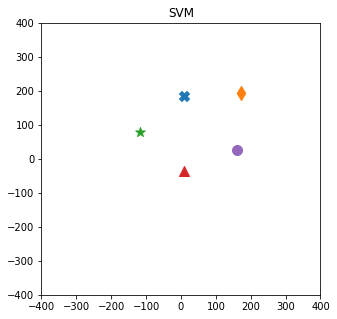

In [26]:
gera_tsne(delta, 'SVM', list(labels), escala=400)

# LogisticRegression

In [0]:
lr = {
    'CV': {
        'CLF': LogisticRegression(random_state=42, verbose=100, multi_class='auto', solver='liblinear', penalty='l1'),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': LogisticRegression(random_state=42, verbose=100, multi_class='auto', solver='liblinear', penalty='l1'),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': LogisticRegression(random_state=42, verbose=100, multi_class='auto', solver='liblinear', penalty='l1'),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': LogisticRegression(random_state=42, verbose=100, multi_class='auto', solver='liblinear', penalty='l1'),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': LogisticRegression(random_state=42, verbose=100, multi_class='auto', solver='liblinear', penalty='l1'),
        'EXT': fasttext,
    }
}

In [28]:
lr_clfs = {

}
for ext, clf in lr.items():
    lr_clfs[ext] = get_classifier(clf['CLF'], train, df_train['class'], clf['EXT'])


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [0]:
pre_lr = {

}
for ext, clf in lr_clfs.items():
    pre_lr['LR-'+ext] = clf.predict(val)

In [0]:
delta, labels = calc_delta(df_val['class'], pre_lr, pre_lr.keys())

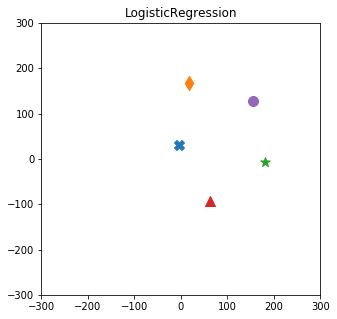

In [31]:
gera_tsne(delta, 'LogisticRegression', list(labels), escala=300)

In [0]:
pre.update(pre_lr)

# RandomForest

In [0]:
rf = {
    'CV': {
        'CLF': RandomForestClassifier(random_state=42, verbose=100, n_estimators=20),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': RandomForestClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': RandomForestClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': RandomForestClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': RandomForestClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT': fasttext,
    }
}

In [34]:
rf_clfs = {

}
for ext, clf in rf.items():
    rf_clfs[ext] = get_classifier(clf['CLF'], train, df_train['class'], clf['EXT'])


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 20
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
building tree 2 of 20
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
building tree 3 of 20
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
building tree 4 of 20
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
building tree 5 of 20
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
building tree 6 of 20
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.0s remaining:    0.0s
building tree 7 of 20
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.1s remaining:    0.0s
building tree 8 of 20
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.3s remaining:    0.0s
building tree 9 of 20
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.5s remaining:    0.0s
b

In [35]:
pre_rf = {

}
for ext, clf in rf_clfs.items():
    pre_rf['RF-'+ext] = clf.predict(val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [0]:
delta, labels = calc_delta(df_val['class'], pre_rf, pre_rf.keys())

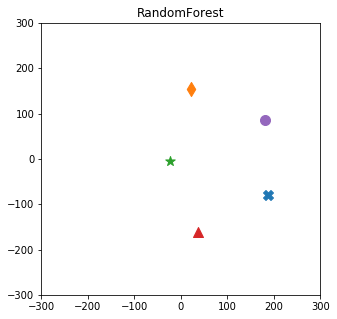

In [37]:
gera_tsne(delta, 'RandomForest', list(labels), escala=300)

In [0]:
pre.update(pre_rf)

# NaiveBayes

In [0]:
nb = {
    'CV': {
        'CLF': MultinomialNB(alpha=1, fit_prior=False),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': MultinomialNB(alpha=0.5, fit_prior=False),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': BernoulliNB(alpha=0.5, fit_prior=True),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': BernoulliNB(alpha=0.1, fit_prior=True),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': BernoulliNB(alpha=1, fit_prior=True),
        'EXT': fasttext,
    }
}

In [0]:
nb_clfs = {

}
for ext, clf in nb.items():
    nb_clfs[ext] = get_classifier(clf['CLF'], train, df_train['class'], clf['EXT'])


In [0]:
pre_nb = {

}
for ext, clf in nb_clfs.items():
    pre_nb['NB-'+ext] = clf.predict(val)

In [0]:
delta, labels = calc_delta(df_val['class'], pre_nb, pre_nb.keys())

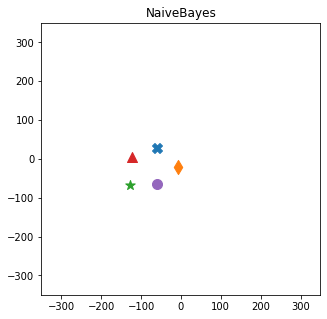

In [43]:
gera_tsne(delta, 'NaiveBayes', list(labels), escala=350)

In [0]:
pre.update(pre_nb)

# MLP

In [0]:
mlp = {
    'CV': {
        'CLF': MLPClassifier(random_state=42, batch_size=20, max_iter=20, verbose=100, activation='relu', solver='lbfgs'),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': MLPClassifier(random_state=42, batch_size=20, max_iter=20, verbose=100, activation='logistic', solver='adam'),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': MLPClassifier(random_state=42, batch_size=20, max_iter=20, verbose=100, activation='relu', solver='adam'),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': MLPClassifier(random_state=42, batch_size=20, max_iter=20, verbose=100, activation='relu', solver='adam'),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': MLPClassifier(random_state=42, batch_size=20, max_iter=20, verbose=100, activation='relu', solver='adam'),
        'EXT': fasttext,
    }
}

In [46]:
mlp_clfs = {

}
for ext, clf in mlp.items():
    mlp_clfs[ext] = get_classifier(clf['CLF'], train, df_train['class'], clf['EXT'])


Iteration 1, loss = 0.60941986
Iteration 2, loss = 0.41521054
Iteration 3, loss = 0.30750962
Iteration 4, loss = 0.25374964
Iteration 5, loss = 0.21959876
Iteration 6, loss = 0.19513646
Iteration 7, loss = 0.17652194
Iteration 8, loss = 0.16174140
Iteration 9, loss = 0.14984757
Iteration 10, loss = 0.13980109
Iteration 11, loss = 0.13132903
Iteration 12, loss = 0.12438988
Iteration 13, loss = 0.11802265
Iteration 14, loss = 0.11269725
Iteration 15, loss = 0.10788111
Iteration 16, loss = 0.10334254
Iteration 17, loss = 0.10010296
Iteration 18, loss = 0.09632147
Iteration 19, loss = 0.09383296
Iteration 20, loss = 0.09094837


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.47096438
Iteration 2, loss = 0.40325746
Iteration 3, loss = 0.38423555
Iteration 4, loss = 0.37239274
Iteration 5, loss = 0.36178605
Iteration 6, loss = 0.35188223
Iteration 7, loss = 0.34173046
Iteration 8, loss = 0.33450757
Iteration 9, loss = 0.32556258
Iteration 10, loss = 0.31724949
Iteration 11, loss = 0.31054098
Iteration 12, loss = 0.30246049
Iteration 13, loss = 0.29497105
Iteration 14, loss = 0.28648034
Iteration 15, loss = 0.27953092
Iteration 16, loss = 0.27336929
Iteration 17, loss = 0.26443955
Iteration 18, loss = 0.25756238
Iteration 19, loss = 0.25052649
Iteration 20, loss = 0.24392953


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.51324616
Iteration 2, loss = 0.48328811
Iteration 3, loss = 0.47602715
Iteration 4, loss = 0.46867845
Iteration 5, loss = 0.46579464
Iteration 6, loss = 0.46111646
Iteration 7, loss = 0.45723375
Iteration 8, loss = 0.45548453
Iteration 9, loss = 0.45215457
Iteration 10, loss = 0.44906359
Iteration 11, loss = 0.44807205
Iteration 12, loss = 0.44462039
Iteration 13, loss = 0.44277098
Iteration 14, loss = 0.44035827
Iteration 15, loss = 0.43859533
Iteration 16, loss = 0.43706094
Iteration 17, loss = 0.43554432
Iteration 18, loss = 0.43325094
Iteration 19, loss = 0.43281282
Iteration 20, loss = 0.43097964


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.50055697
Iteration 2, loss = 0.40483245
Iteration 3, loss = 0.38585786
Iteration 4, loss = 0.37354835
Iteration 5, loss = 0.36551086
Iteration 6, loss = 0.35913265
Iteration 7, loss = 0.35193565
Iteration 8, loss = 0.34805301
Iteration 9, loss = 0.34321217
Iteration 10, loss = 0.33780297
Iteration 11, loss = 0.33535158
Iteration 12, loss = 0.33160899
Iteration 13, loss = 0.32785932
Iteration 14, loss = 0.32211126
Iteration 15, loss = 0.31972493
Iteration 16, loss = 0.31649134
Iteration 17, loss = 0.31222652
Iteration 18, loss = 0.30881306
Iteration 19, loss = 0.30596117
Iteration 20, loss = 0.30269560


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [0]:
pre_mlp = {

}
for ext, clf in mlp_clfs.items():
    pre_mlp['MLP-'+ext] = clf.predict(val)

In [0]:
delta, labels = calc_delta(df_val['class'], pre_mlp, pre_mlp.keys())

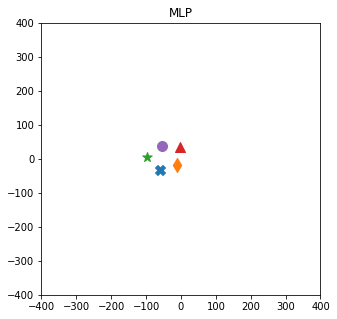

In [49]:
gera_tsne(delta, 'MLP', list(labels), escala=400)

In [0]:
pre.update(pre_mlp)

# ExtraTrees

In [0]:
extra = {
    'CV': {
        'CLF': ExtraTreesClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': ExtraTreesClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': ExtraTreesClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': ExtraTreesClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': ExtraTreesClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT': fasttext,
    }
}

In [52]:
extra_clfs = {

}
for ext, clf in extra.items():
    extra_clfs[ext] = get_classifier(clf['CLF'], train, df_train['class'], clf['EXT'])


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 50
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
building tree 2 of 50
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
building tree 3 of 50
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
building tree 4 of 50
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s
building tree 5 of 50
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
building tree 6 of 50
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.6s remaining:    0.0s
building tree 7 of 50
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.9s remaining:    0.0s
building tree 8 of 50
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.2s remaining:    0.0s
building tree 9 of 50
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.4s remaining:    0.0s
b

In [53]:
pre_extra = {

}
for ext, clf in extra_clfs.items():
    pre_extra['EXTRA-'+ext] = clf.predict(val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [0]:
delta, labels = calc_delta(df_val['class'], pre_extra, pre_extra.keys())

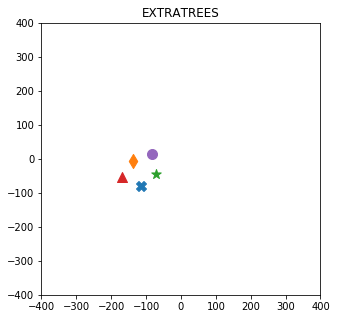

In [55]:
gera_tsne(delta, 'EXTRATREES', list(labels), escala=400)

In [0]:
pre.update(pre_extra)

# KNN

In [0]:
knn = {
    'CV': {
        'CLF': KNeighborsClassifier(n_neighbors=3, algorithm='auto'),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': KNeighborsClassifier(n_neighbors=5, algorithm='auto'),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': KNeighborsClassifier(n_neighbors=5, algorithm='auto'),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree'),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': KNeighborsClassifier(n_neighbors=5, algorithm='auto'),
        'EXT': fasttext,
    }
}

In [0]:
knn_clfs = { }
for ext, clf in knn.items():
    knn_clfs[ext] = get_classifier(clf['CLF'], train, df_train['class'], clf['EXT'])

In [0]:
pre_knn = { }
for ext, clf in knn_clfs.items():
    pre_knn['KNN-'+ext] = clf.predict(val)

In [0]:
delta, labels = calc_delta(df_val['class'], pre_knn, pre_knn.keys())

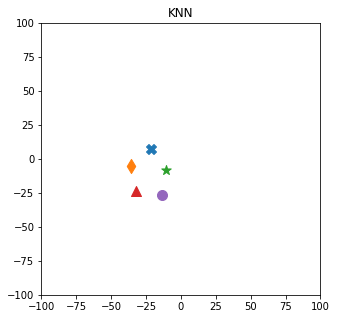

In [146]:
gera_tsne(delta, 'KNN', list(labels), escala=100)

In [0]:
pre.update(pre_knn)

# CNN

In [0]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH=300

y_train = to_categorical(df_train['class'])
y_val = to_categorical(df_val['class'])

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train)

In [0]:
seq_train = tokenizer.texts_to_sequences(train)
seq_val = tokenizer.texts_to_sequences(val)
seq_test = tokenizer.texts_to_sequences(test)

In [0]:
data_train = pad_sequences(seq_train, maxlen=MAX_SEQUENCE_LENGTH)
data_val = pad_sequences(seq_val, maxlen=MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(seq_test, maxlen=MAX_SEQUENCE_LENGTH)

In [67]:
cnn_cv = get_CNN(cv, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM=300, activation='sigmoid')











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          4950600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 298, 64)           57664     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0     

In [68]:
cnn_cv.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=20)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16604 samples, validate on 4090 samples
Epoch 1/20
16604/16604 [==============================] - 6s 370us/step - loss: 0.5554 - acc: 0.7777 - val_loss: 0.4231 - val_acc: 0.8161
Epoch 2/20
16604/16604 [==============================] - 3s 166us/step - loss: 0.4211 - acc: 0.8197 - val_loss: 0.3945 - val_acc: 0.8401
Epoch 3/20
16604/16604 [==============================] - 3s 166us/step - loss: 0.3969 - acc: 0.8441 - val_loss: 0.3976 - val_acc: 0.8403
Epoch 4/20
16604/16604 [==============================] - 3s 166us/step - loss: 0.3700 - acc: 0.8686 - val_loss: 0.3490 - val_acc: 0.8719
Epoch 5/20
16604/16604 [==============================] - 3s 165us/step - loss: 0.3486 - acc: 0.8801 - val_loss: 0.3357 - val_acc: 0.8797
Epoch 6/20
16604/16604 [==============================] - 3s 167us/step - loss: 0.3299 - acc: 0.8888 - val_loss: 0.3124 - val_acc: 0.8917
Epoch 7/20
16604/16604 [===

In [69]:
cnn_tfidf = get_CNN(tfidf, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM=300, activation='softmax')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          4950600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 298, 64)           57664     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 256)              

In [70]:
cnn_tfidf.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=200)

Train on 16604 samples, validate on 4090 samples
Epoch 1/20
16604/16604 [==============================] - 1s 65us/step - loss: 0.6839 - acc: 0.7690 - val_loss: 0.6070 - val_acc: 0.7773
Epoch 2/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.5367 - acc: 0.7742 - val_loss: 0.4693 - val_acc: 0.7773
Epoch 3/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.4524 - acc: 0.7993 - val_loss: 0.4481 - val_acc: 0.8088
Epoch 4/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.4231 - acc: 0.8216 - val_loss: 0.4150 - val_acc: 0.8134
Epoch 5/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.4078 - acc: 0.8337 - val_loss: 0.3995 - val_acc: 0.8274
Epoch 6/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.3950 - acc: 0.8456 - val_loss: 0.4173 - val_acc: 0.8306
Epoch 7/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.3829 - acc: 0.8571 - val_loss: 0.3679 - val_acc:

In [71]:
cnn_w2v = get_CNN(w2v, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM=300, activation='sigmoid', word_embedding=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          4950600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 298, 64)           57664     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 256)              

In [72]:
cnn_w2v.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=200)

Train on 16604 samples, validate on 4090 samples
Epoch 1/20
16604/16604 [==============================] - 1s 65us/step - loss: 0.4348 - acc: 0.8416 - val_loss: 0.3186 - val_acc: 0.8826
Epoch 2/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.3146 - acc: 0.8869 - val_loss: 0.3264 - val_acc: 0.8738
Epoch 3/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.2867 - acc: 0.8965 - val_loss: 0.3110 - val_acc: 0.8812
Epoch 4/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.2627 - acc: 0.9058 - val_loss: 0.2699 - val_acc: 0.9000
Epoch 5/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.2485 - acc: 0.9115 - val_loss: 0.2764 - val_acc: 0.8968
Epoch 6/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.2328 - acc: 0.9164 - val_loss: 0.2743 - val_acc: 0.8995
Epoch 7/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.2154 - acc: 0.9233 - val_loss: 0.3860 - val_acc:

In [73]:
cnn_glove = get_CNN(glove, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM=25, activation='sigmoid', word_embedding=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 25)           412550    
_________________________________________________________________
dropout_7 (Dropout)          (None, 300, 25)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 298, 64)           4864      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_7 (Activation)    (None, 256)              

In [74]:
cnn_glove.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=200)

Train on 16604 samples, validate on 4090 samples
Epoch 1/20
16604/16604 [==============================] - 1s 43us/step - loss: 0.5391 - acc: 0.8040 - val_loss: 0.5148 - val_acc: 0.8286
Epoch 2/20
16604/16604 [==============================] - 0s 21us/step - loss: 0.4298 - acc: 0.8536 - val_loss: 0.4304 - val_acc: 0.8677
Epoch 3/20
16604/16604 [==============================] - 0s 21us/step - loss: 0.3970 - acc: 0.8656 - val_loss: 0.4935 - val_acc: 0.8298
Epoch 4/20
16604/16604 [==============================] - 0s 20us/step - loss: 0.3788 - acc: 0.8735 - val_loss: 0.4865 - val_acc: 0.8704
Epoch 5/20
16604/16604 [==============================] - 0s 20us/step - loss: 0.3662 - acc: 0.8772 - val_loss: 0.3538 - val_acc: 0.8861
Epoch 6/20
16604/16604 [==============================] - 0s 21us/step - loss: 0.3579 - acc: 0.8787 - val_loss: 0.3502 - val_acc: 0.8667
Epoch 7/20
16604/16604 [==============================] - 0s 20us/step - loss: 0.3496 - acc: 0.8794 - val_loss: 0.3204 - val_acc:

In [75]:
cnn_fast = get_CNN(fasttext, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM=300, activation='sigmoid', word_embedding=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 300)          4950600   
_________________________________________________________________
dropout_9 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 298, 64)           57664     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_9 (Activation)    (None, 256)              

In [76]:
cnn_fast.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=200)

Train on 16604 samples, validate on 4090 samples
Epoch 1/20
16604/16604 [==============================] - 1s 70us/step - loss: 0.4848 - acc: 0.8206 - val_loss: 0.5288 - val_acc: 0.8315
Epoch 2/20
16604/16604 [==============================] - 1s 49us/step - loss: 0.3255 - acc: 0.8860 - val_loss: 0.3540 - val_acc: 0.8636
Epoch 3/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.2953 - acc: 0.8928 - val_loss: 0.3058 - val_acc: 0.8829
Epoch 4/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.2727 - acc: 0.9005 - val_loss: 0.3240 - val_acc: 0.8927
Epoch 5/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.2591 - acc: 0.9071 - val_loss: 0.3383 - val_acc: 0.8753
Epoch 6/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.2496 - acc: 0.9097 - val_loss: 0.2761 - val_acc: 0.9002
Epoch 7/20
16604/16604 [==============================] - 1s 48us/step - loss: 0.2372 - acc: 0.9148 - val_loss: 0.3291 - val_acc:

In [0]:
pre_cnn = {
    'CNN-CV': np.argmax(cnn_cv.predict(data_val), axis=1),
    'CNN-TFIDF': np.argmax(cnn_tfidf.predict(data_val), axis=1),
    'CNN-W2V': np.argmax(cnn_w2v.predict(data_val), axis=1),
    'CNN-GLOVE': np.argmax(cnn_glove.predict(data_val), axis=1),
    'CNN-FAST': np.argmax(cnn_fast.predict(data_val), axis=1),
}

In [0]:
delta, labels = calc_delta(df_val['class'], pre_cnn, pre_cnn.keys())

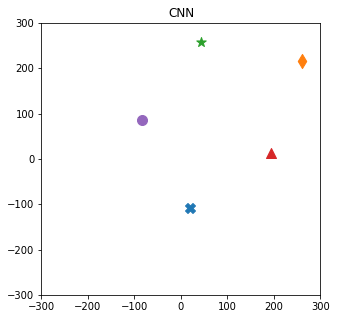

In [79]:
gera_tsne(delta, 'CNN', list(labels), escala=300)

In [0]:
pre.update(pre_cnn)

# PREDICT TEST

In [0]:
pre_test = {}

for ext, clf in svm_clfs.items():
    pre_test['SVM-'+ext] = clf.predict(test)

In [0]:
for ext, clf in lr_clfs.items():
    pre_test['LR-'+ext] = clf.predict(test)

In [83]:
for ext, clf in rf_clfs.items():
    pre_test['RF-'+ext] = clf.predict(test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [0]:
for ext, clf in nb_clfs.items():
    pre_test['NB-'+ext] = clf.predict(test)

In [0]:
for ext, clf in mlp_clfs.items():
    pre_test['MLP-'+ext] = clf.predict(test)

In [86]:
for ext, clf in extra_clfs.items():
    pre_test['EXTRA-'+ext] = clf.predict(test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [0]:
for ext, clf in knn_clfs.items():
    pre_test['KNN-'+ext] = clf.predict(test)

In [0]:
pre_test['CNN-CV'] = np.argmax(cnn_cv.predict(data_test), axis=1)
pre_test['CNN-TFIDF'] = np.argmax(cnn_tfidf.predict(data_test), axis=1)
pre_test['CNN-W2V'] = np.argmax(cnn_w2v.predict(data_test), axis=1)
pre_test['CNN-GLOVE'] = np.argmax(cnn_glove.predict(data_test), axis=1)
pre_test['CNN-FAST'] = np.argmax(cnn_fast.predict(data_test), axis=1)

In [89]:
k = 0
for clf, pre_clf in pre_test.items():
    print(clf)
    print(f1_score(class_test, pre_clf, average='macro'))
    print(accuracy_score(class_test, pre_clf))
    k += 1
    if k % 5 == 0:
        print("")
    

SVM-CV
0.6996949300977103
0.8975299584250428
SVM-TFIDF
0.683903106810294
0.9060895084372708
SVM-W2V
0.5403381320039579
0.8473954512105649
SVM-GLOVE
0.5072339434574643
0.8290535583272194
SVM-FAST
0.5372873051525895
0.85155294693079

LR-CV
0.7061946317764202
0.9068231841526045
LR-TFIDF
0.6798583410033484
0.9026656884323796
LR-W2V
0.5397536876895024
0.8378576669112252
LR-GLOVE
0.48428563655007156
0.8217168011738811
LR-FAST
0.5481235089092872
0.8456835412081194

RF-CV
0.6996712135588782
0.8938615798483737
RF-TFIDF
0.6718619085460568
0.9002201027146002
RF-W2V
0.4836414163407839
0.8202494497432135
RF-GLOVE
0.5005444316590708
0.8219613597456591
RF-FAST
0.49473525749826747
0.8268525311812179

NB-CV
0.678153415932599
0.880410858400587
NB-TFIDF
0.6431472612527828
0.8542430912203473
NB-W2V
0.5304511068909745
0.7493274639276106
NB-GLOVE
0.48194756102954345
0.7994619711420885
NB-FAST
0.5734328322927237
0.7723159696747371

MLP-CV
0.6926028578467603
0.8953289312790413
MLP-TFIDF
0.6876818000461355
0.8

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# ORACLE

In [90]:
clfs = ['SVM-CV', 'SVM-TFIDF', 'SVM-W2V', 'SVM-GLOVE', 'SVM-FAST']

oracle, df_yes = get_oracle(df_test['class'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['class'], df_yes))
print('F1: ', f1_score(df_test['class'], df_yes, average='macro'))

3882 de 4089
Acc:  0.9493763756419662
F1:  0.7814545785826867


In [91]:
clfs = ['LR-CV', 'LR-TFIDF', 'LR-W2V', 'LR-GLOVE', 'LR-FAST']

oracle, df_yes = get_oracle(df_test['class'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['class'], df_yes))
print('F1: ', f1_score(df_test['class'], df_yes, average='macro'))

3882 de 4089
Acc:  0.9493763756419662
F1:  0.7769870171923238


In [92]:
clfs = ['RF-CV', 'RF-TFIDF', 'RF-W2V', 'RF-GLOVE', 'RF-FAST']

oracle, df_yes = get_oracle(df_test['class'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['class'], df_yes))
print('F1: ', f1_score(df_test['class'], df_yes, average='macro'))

3858 de 4089
Acc:  0.9435069699192957
F1:  0.7596445883390107


In [93]:
clfs = ['NB-CV', 'NB-TFIDF', 'NB-W2V', 'NB-GLOVE', 'NB-FAST']

oracle, df_yes = get_oracle(df_test['class'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['class'], df_yes))
print('F1: ', f1_score(df_test['class'], df_yes, average='macro'))

3871 de 4089
Acc:  0.9466862313524089
F1:  0.8102401792105702


In [94]:
clfs = ['MLP-CV', 'MLP-TFIDF', 'MLP-W2V', 'MLP-GLOVE', 'MLP-FAST']

oracle, df_yes = get_oracle(df_test['class'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['class'], df_yes))
print('F1: ', f1_score(df_test['class'], df_yes, average='macro'))

3907 de 4089
Acc:  0.9554903399364147
F1:  0.8176106620615481


In [95]:
clfs = ['EXTRA-CV', 'EXTRA-TFIDF', 'EXTRA-W2V', 'EXTRA-GLOVE', 'EXTRA-FAST']

oracle, df_yes = get_oracle(df_test['class'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['class'], df_yes))
print('F1: ', f1_score(df_test['class'], df_yes, average='macro'))

3845 de 4089
Acc:  0.9403277084861824
F1:  0.7515660761734061


In [96]:
clfs = ['KNN-CV', 'KNN-TFIDF', 'KNN-W2V', 'KNN-GLOVE', 'KNN-FAST']

oracle, df_yes = get_oracle(df_test['class'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['class'], df_yes))
print('F1: ', f1_score(df_test['class'], df_yes, average='macro'))

3834 de 4089
Acc:  0.9376375641966251
F1:  0.7724467484817703


In [97]:
clfs = ['CNN-CV', 'CNN-TFIDF', 'CNN-W2V', 'CNN-GLOVE', 'CNN-FAST']

oracle, df_yes = get_oracle(df_test['class'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['class'], df_yes))
print('F1: ', f1_score(df_test['class'], df_yes, average='macro'))

3976 de 4089
Acc:  0.9723648813890927
F1:  0.9081084960997048


# TSNE-FULL

In [0]:
delta, cols = calc_delta(df_val['class'], pre, pre.keys())

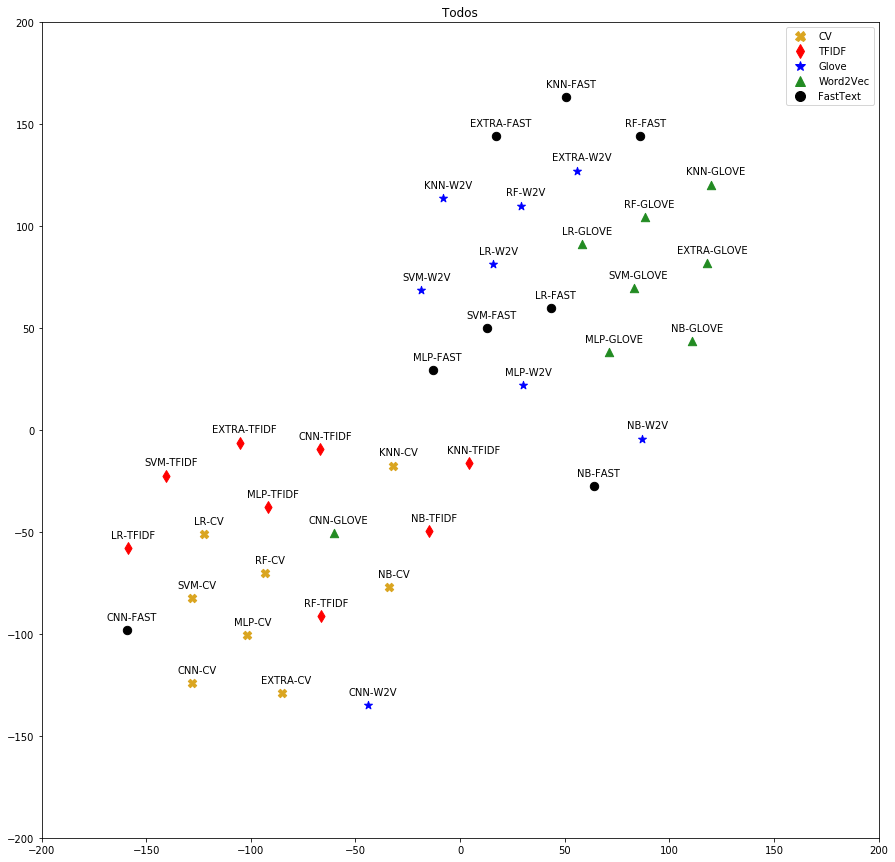

In [99]:
cores = {}
cores[0] = '#DAA520'
cores[1] = '#FF0000'
cores[2] = '#0000FF'
cores[3] = '#228B22'
cores[4] = '#000000'

simbolos = {}
simbolos[0] = 'X'
simbolos[1] = 'd'
simbolos[2] = '*'
simbolos[3] = "^"
simbolos[4] = 'o'

tsne_full(list(cols), delta, 'Todos', cores=cores, simbolos=simbolos, escala=200, per=25, size=15, size_dot=70)

# Oracle Combinados

In [139]:
# TODOS
clfs = list(pre.keys())

oracle, df_yes = get_oracle(df_test['class'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['class'], df_yes))
print('F1: ', f1_score(df_test['class'], df_yes, average='macro'))

4043 de 4089
Acc:  0.9887503056982148
F1:  0.9604786119459551


In [101]:
# EXTERNOS
clfs = ['CNN-FAST', 'RF-CV', 'KNN-TFIDF', 'LR-W2V', 'SVM-GLOVE']

oracle, df_yes = get_oracle(df_test['class'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['class'], df_yes))
print('F1: ', f1_score(df_test['class'], df_yes, average='macro'))

3931 de 4089
Acc:  0.9613597456590853
F1:  0.8364097882833813


In [102]:
clfs = ['CNN-FAST', 'SVM-CV', 'LR-TFIDF', 'LR-CV', 'NB-CV']

oracle, df_yes = get_oracle(df_test['class'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['class'], df_yes))
print('F1: ', f1_score(df_test['class'], df_yes, average='macro'))

3894 de 4089
Acc:  0.9523110785033015
F1:  0.8277069366247168


# VENN

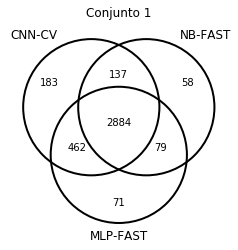

In [103]:
# clfs = ['CNN-CV', 'NB-FAST', 'MLP-FAST', 'KNN-FAST', 'NB-GLOVE']
diagrama_venn(pre_test['CNN-CV'], pre_test['NB-FAST'], pre_test['MLP-FAST'], 'CNN-CV', 'NB-FAST', 'MLP-FAST', 'Conjunto 1')

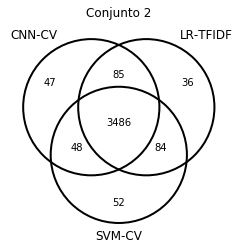

In [104]:
# clfs = ['CNN-CV', 'LR-TFIDF', 'SVM-CV', 'RF-CV', 'MLP-TFIDF']
diagrama_venn(pre_test['CNN-CV'], pre_test['LR-TFIDF'], pre_test['SVM-CV'], 'CNN-CV', 'LR-TFIDF', 'SVM-CV', 'Conjunto 2')

# BAR



In [0]:
list_certos = {
    5: 0, 4: 0, 3: 0, 2:0, 1:0, 0:0
}
EXTS = ['CV','TFIDF', 'W2V','GLOVE', 'FAST']

No handles with labels found to put in legend.


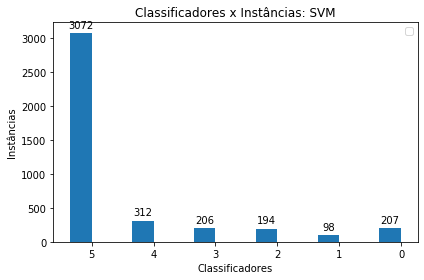

In [106]:
svm_certos = list_certos.copy()
for i, l in enumerate(df_test['class']):
    k = 0
    for ext in EXTS:
        if pre_test['SVM-'+ext][i]==l:
            k += 1
    svm_certos[k] = svm_certos[k]+1

render_bar(svm_certos, title='SVM')

No handles with labels found to put in legend.


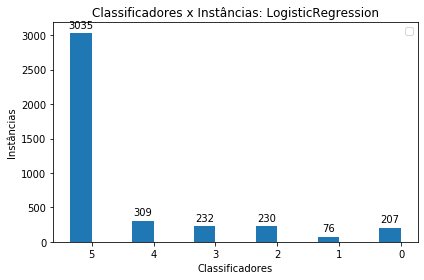

In [107]:
lr_certos = list_certos.copy()
for i, l in enumerate(df_test['class']):
    k = 0
    for ext in EXTS:
        if pre_test['LR-'+ext][i]==l:
            k += 1
    lr_certos[k] = lr_certos[k]+1

render_bar(lr_certos, title='LogisticRegression')

No handles with labels found to put in legend.


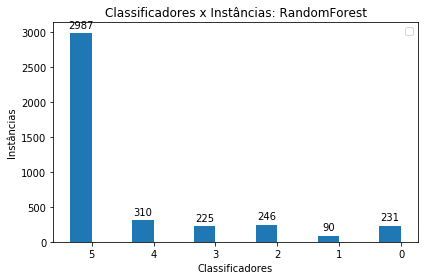

In [108]:
rf_certos = list_certos.copy()
for i, l in enumerate(df_test['class']):
    k = 0
    for ext in EXTS:
        if pre_test['RF-'+ext][i]==l:
            k += 1
    rf_certos[k] = rf_certos[k]+1

render_bar(rf_certos, title='RandomForest')

No handles with labels found to put in legend.


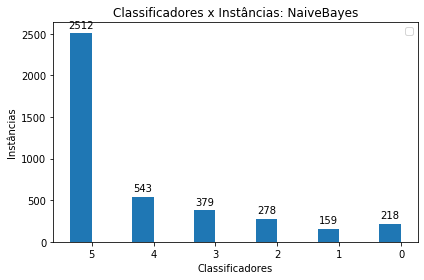

In [109]:
nb_certos = list_certos.copy()
for i, l in enumerate(df_test['class']):
    k = 0
    for ext in EXTS:
        if pre_test['NB-'+ext][i]==l:
            k += 1
    nb_certos[k] = nb_certos[k]+1

render_bar(nb_certos, title='NaiveBayes')

No handles with labels found to put in legend.


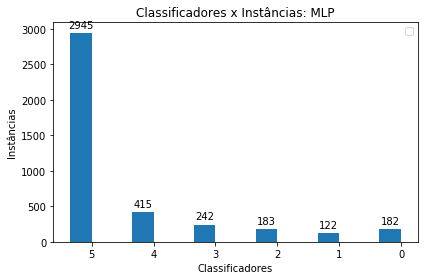

In [110]:
mlp_certos = list_certos.copy()
for i, l in enumerate(df_test['class']):
    k = 0
    for ext in EXTS:
        if pre_test['MLP-'+ext][i]==l:
            k += 1
    mlp_certos[k] = mlp_certos[k]+1

render_bar(mlp_certos, title='MLP')

No handles with labels found to put in legend.


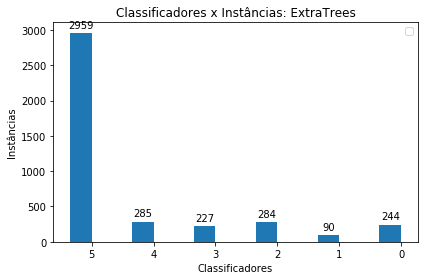

In [111]:
extra_certos = list_certos.copy()
for i, l in enumerate(df_test['class']):
    k = 0
    for ext in EXTS:
        if pre_test['EXTRA-'+ext][i]==l:
            k += 1
    extra_certos[k] = extra_certos[k]+1

render_bar(extra_certos, title='ExtraTrees')

No handles with labels found to put in legend.


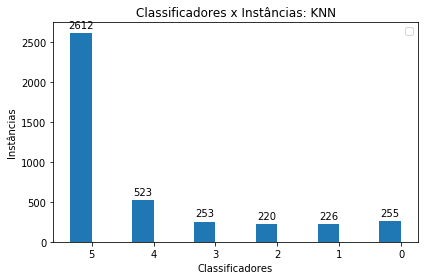

In [112]:
knn_certos = list_certos.copy()
for i, l in enumerate(df_test['class']):
    k = 0
    for ext in EXTS:
        if pre_test['KNN-'+ext][i]==l:
            k += 1
    knn_certos[k] = knn_certos[k]+1

render_bar(knn_certos, title='KNN')

No handles with labels found to put in legend.


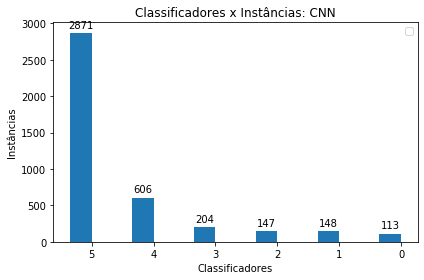

In [113]:
cnn_certos = list_certos.copy()
for i, l in enumerate(df_test['class']):
    k = 0
    for ext in EXTS:
        if pre_test['CNN-'+ext][i]==l:
            k += 1
    cnn_certos[k] = cnn_certos[k]+1

render_bar(cnn_certos, title='CNN')

No handles with labels found to put in legend.


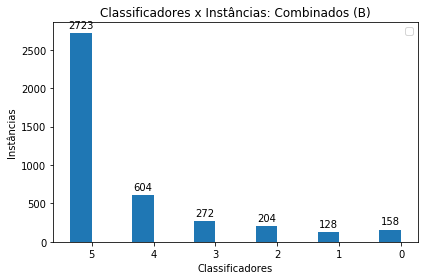

In [160]:
clfs_combinados = ['CNN-FAST', 'RF-CV', 'KNN-TFIDF', 'LR-W2V', 'SVM-GLOVE']
clfs_combinados_certos = list_certos.copy()
for i, l in enumerate(df_test['class']):
    k = 0
    for clf in clfs_combinados:
        if pre_test[clf][i]==l:
            k += 1
    clfs_combinados_certos[k] = clfs_combinados_certos[k]+1

render_bar(clfs_combinados_certos, title='Combinados (B)', size_x=4, size_y=6)

No handles with labels found to put in legend.


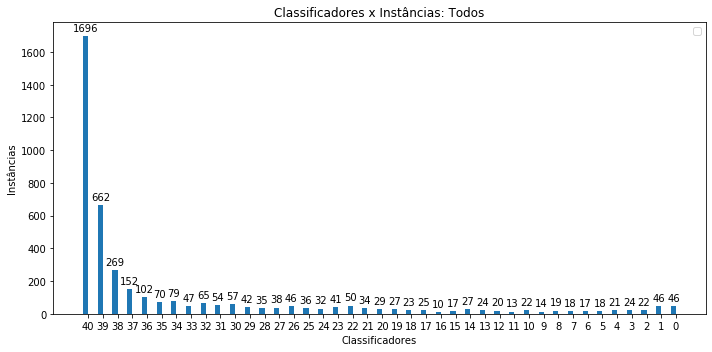

In [162]:
clfs_todos = list(pre.keys())
clfs_todos_certos = {k:0 for k in range(len(clfs_todos), -1, -1)}
# print(clfs_todos_certos)
for i, l in enumerate(df_test['class']):
    k = 0
    for clf in clfs_todos:
        if pre_test[clf][i]==l:
            k += 1
    clfs_todos_certos[k] = clfs_todos_certos[k]+1
render_bar(clfs_todos_certos, title='Todos', size_x=5, size_y=10)

# COMBINE

In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, svm_clfs)

In [117]:
print("SVM")
print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

SVM
Voting
0.6056341907550814
0.880410858400587
Average
0.6130555154027507
0.892638786989484
Maximun
0.6426386645074987
0.8945952555637076
Minimun
0.6310058755587278
0.8938615798483737
Median
0.5902673759788791
0.879921741257031
Product
0.6177547535303702
0.8945952555637076


In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, lr_clfs)


In [119]:
print("Logistic Regression")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

Logistic Regression
Voting
0.5967779460372734
0.8755196869650281
Average
0.6011302481723882
0.8875030569821473
Maximun
0.6027191784176119
0.8831010026901442
Minimun
0.5915829542773894
0.8818782098312545
Median
0.5916513721925662
0.8755196869650281
Product
0.5962378583037995
0.8855465884079237


In [120]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, rf_clfs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [121]:
print("RandomForest")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

RandomForest
Voting
0.5800281913201396
0.8640254340914649
Average
0.5952990902528279
0.8813890926876987
Maximun
0.6307301318547309
0.8872584984103693
Minimun
0.5949109831931229
0.8816336512594767
Median
0.5595610749955092
0.8628026412325752
Product
0.5983126755471758
0.8821227684030325


In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, nb_clfs)

In [123]:
print("Naive Bayes")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

Naive Bayes
Voting
0.6138298361261093
0.8498410369283443
Average
0.5987293430498138
0.8410369283443385
Maximun
0.5819314503546419
0.8050868182929811
Minimun
0.5833034561392721
0.8031303497187576
Median
0.6043424367712436
0.8508192712154561
Product
0.6039507713785883
0.8290535583272194


In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, mlp_clfs)

In [125]:
print("MLP")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

MLP
Voting
0.6181147289555564
0.8823673269748105
Average
0.6268473647012168
0.8909268769870384
Maximun
0.6634907137042804
0.892394228417706
Minimun
0.6390735294695034
0.8901932012717045
Median
0.612929957801457
0.8823673269748105
Product
0.6341281643768025
0.8933724627048178


In [126]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, extra_clfs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [127]:
print("ExtraTrees")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

ExtraTrees
Voting
0.5442460871257405
0.8503301540719003
Average
0.5832438827539957
0.8764979212521399
Maximun
0.6268006044547468
0.8816336512594767
Minimun
0.6087747581301431
0.8806554169723649
Median
0.5318878584752618
0.8500855955001223
Product
0.5966209766819871
0.8772315969674737


In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, knn_clfs)

In [129]:
print("KNN")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

KNN
Voting
0.5311373317284772
0.8332110540474443
Average
0.517065605795631
0.8366348740523355
Maximun
0.5248397823309824
0.8310100269014429
Minimun
0.5080163592497143
0.8195157740278797
Median
0.5115390873677789
0.8327219369038885
Product
0.5149415273488113
0.8253851797505503


In [0]:
cnn_clfs = {
    'CV':cnn_cv, 'TFIDF':cnn_tfidf, 'W2V': cnn_w2v, 'GLOVE': cnn_glove, 'FAST': cnn_fast
}
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(data_test, cnn_clfs, cnn=True)

In [131]:
print("CNN")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

CNN
Voting
0.7006418160397528
0.9060895084372708
Average
0.6867772951608643
0.9095133284421619
Maximun
0.7045838525593021
0.9065786255808266
Minimun
0.7161602905856782
0.9029102470041575
Median
0.6535126809316004
0.9075568598679383
Product
0.7196055645762912
0.9107361213010516


In [0]:
full_clfs = {}
for ext, clf in svm_clfs.items():
    full_clfs['SVM-'+ext] = clf

for ext, clf in lr_clfs.items():
    full_clfs['LR-'+ext] = clf

for ext, clf in rf_clfs.items():
    full_clfs['RF-'+ext] = clf

for ext, clf in nb_clfs.items():
    full_clfs['NB-'+ext] = clf

for ext, clf in mlp_clfs.items():
    full_clfs['MLP-'+ext] = clf

for ext, clf in extra_clfs.items():
    full_clfs['EXTRA-'+ext] = clf

for ext, clf in knn_clfs.items():
    full_clfs['KNN-'+ext] = clf

for ext, clf in cnn_clfs.items():
    full_clfs['CNN-'+ext] = clf

In [133]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine_all(test, data_test, clfs=full_clfs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [134]:
print("Completo")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

Completo
Voting
0.6074008353548263
0.8875030569821473
Average
0.618645019426193
0.892394228417706
Maximun
0.6004478265464812
0.8549767669356811
Minimun
0.5677162608479321
0.8412814869161164
Median
0.6039050656412567
0.8872584984103693
Product
0.5670424614258592
0.8417706040596723


In [135]:
clfs_combine = {
    'CNN-FAST': full_clfs['CNN-FAST'], 'RF-CV': full_clfs['RF-CV'], 'KNN-TFIDF': full_clfs['KNN-TFIDF'], 
    'LR-W2V': full_clfs['LR-W2V'], 'SVM-GLOVE': full_clfs['SVM-GLOVE']
}
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine_all(test, data_test, clfs=clfs_combine)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [136]:
print("Combinado dissimilar")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

Combinado dissimilar
Voting
0.6431351599649967
0.8835901198337002
Average
0.6070005587797063
0.8877476155539251
Maximun
0.60393532041009
0.8789435069699193
Minimun
0.6693218112095
0.9033993641477134
Median
0.5988115437568801
0.8752751283932502
Product
0.6333614324984921
0.9036439227194913


In [0]:
clfs_combine = {
    'CNN-FAST': full_clfs['CNN-FAST'], 'SVM-CV': full_clfs['SVM-CV'], 'LR-TFIDF': full_clfs['LR-TFIDF'], 
    'LR-CV': full_clfs['LR-CV'], 'NB-CV': full_clfs['NB-CV']
}
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine_all(test, data_test, clfs=clfs_combine)

In [138]:
print("Combinado Similar")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

Combinado Similar
Voting
0.7104829815904035
0.9095133284421619
Average
0.6973736715472453
0.9073123012961605
Maximun
0.6888265016875851
0.9016874541452677
Minimun
0.7045730348397367
0.9060895084372708
Median
0.7065177705247808
0.9097578870139399
Product
0.6987636679235072
0.9107361213010516
